In [1]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph,distance_plots
import pandas as pd
from scipy.spatial import distance_matrix
import json
import dataframe_image as dfi

In [2]:

name="1st_sub_top_no_resize"+".json"
with open(name, 'r') as f: 
  meta = json.load(f)
#needed from base file
epoch_conversions= [431, 431, 431, 431, 431, 431] #specify by orginal file
#Gc Clusters
#[431, 1208, 2727, 3812, 3455, 1873]
#resize
#topology
#[561, 561, 561, 561]
#GC
#[431, 431, 431, 431, 431, 431]
#general number for 5 features (these manually need to be changed)
byte=268  
resolution=500
epochs=500
g_comp=6
#getting data files
processed=get_processed_data()
var=.9
#this code should not matter
interest=["H2@100 bar/243K (wt%)"]
interest2 = ['H2@100 bar/77K (wt%)']
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=False)
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=False)
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],interest2[0],'topology']]=data[['MOF ID',interest[0],interest2[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],interest2[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

In [3]:
map={
"Cluster 0":['bcs'],

"Cluster 1":['bct'],

"Cluster 2":['bcu'],

"Cluster 3":['fcu'],

"Cluster 4":['ith'],
}
large={}
for i in map:
    for g in map[i]:
        large[g]=i
        print(len(i))
abridge.groupby("topology").median()
abridge["topology_1"]=abridge["topology"].map(large)

9
9
9
9
9


<ipython-input-3-338ec7dd7d30>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge["topology_1"]=abridge["topology"].map(large)


In [5]:
%%capture
#surpressing output because it is depreciated, plots are generated later with a df for clarity, this only serves to get df outputs now
Cluster_colors=[
[0.267004, 0.004874, 0.329415, 1.      ],
[0.253935, 0.265254, 0.529983, 1.      ],
[0.163625, 0.471133, 0.558148, 1.      ],
[0.134692, 0.658636, 0.517649, 1.      ],
[0.477504, 0.821444, 0.318195, 1.      ],
[0.993248, 0.906157, 0.143936, 1.      ]]
dic,dic2,std=create_dictionaries(g_comp)
dic=unpack_dic(dic,meta)
keys=[]
for i in dic:
    if not dic[i]:
        keys.append(i)
for i in keys:
    dic.pop(i)
std=create_std_matrix(dic,std)
dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2,adjust=100,save=True)
keys=[]
for i in dic2:
    if not dic2[i]:
        keys.append(i)
for i in keys:
    dic2.pop(i)
master=Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std,epochs,save=False)
hold=pd.DataFrame()
hold[['Pc1', 'Pc2',"topology_1"]]=abridge[['Pc1', 'Pc2',"topology_1"]]
display(hold.groupby("topology_1").median())
distances=distance_matrix(hold.groupby("topology_1").median(),hold.groupby("topology_1").median())
m1=make_distance_graph(dic,distances,Cluster_colors,"PC1 and PC2",save=False)
hold=pd.DataFrame()
hold[['Pc1',"topology_1"]]=abridge[['Pc1',"topology_1"]]
display(hold.groupby("topology_1").median())
distances=distance_matrix(hold.groupby("topology_1").median(),hold.groupby("topology_1").median())
m2=make_distance_graph(dic,distances,Cluster_colors,"PC1",save=False)
hold=pd.DataFrame()
hold[['Pc2',"topology_1"]]=abridge[['Pc2',"topology_1"]]
display(hold.groupby("topology_1").median())
distances=distance_matrix(hold.groupby("topology_1").median(),hold.groupby("topology_1").median())
m3=make_distance_graph(dic,distances,Cluster_colors,"PC2",save=False)

IndexError: index 2 is out of bounds for axis 0 with size 2

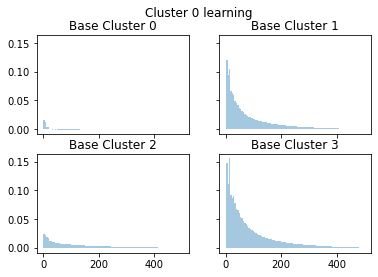

In [6]:
import numpy as np
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[int(g)][count]=np.array(base[int(g)][count])+np.array(z)
anaylsis(base,adjust=100)

In [7]:
main_df=pd.DataFrame()
sets=["set1","set2","set3"]
for count,i in enumerate(zip(m1,m2,m3)):
    a,b,c=i
    df=pd.DataFrame(m1[a]).T
    #display(df)
    df=df.reset_index(drop=False)
    df.columns=["Cluster","Distance",'Mean','Std']
    df["PC1 distance"]=pd.DataFrame(m2[b]).T[0]
    df["PC2 distance"]=pd.DataFrame(m3[c]).T[0]
    df[["Avg Worst (R^2 deviation)","Worst Std"]]=pd.DataFrame(master[(count,'set1')]).T
    df[["Avg Info. (MB to reach 95% Final)","Info Std"]]=pd.DataFrame(master[(count,'set2')]).T
    df[["Avg Learn (Net R^2 to reach 95% Final)","Learn Std"]]=pd.DataFrame(master[(count,'set3')]).T
    df["Base Cluster"]=count
    main_df=pd.concat([main_df,df],axis=0)
colors={}
for count,i in enumerate(Cluster_colors):
    colors[count]=i
real_df=main_df.sort_values(by="Distance").__deepcopy__()
real_df=real_df.replace("Over",0)
real_df=real_df.apply(abs)
real_df["color"]=real_df["Cluster"].map(colors)
groupped=real_df.groupby(["Base Cluster","Cluster"]).sum().replace(0,"N/A")
dfi.export(groupped, 'groupped.png')

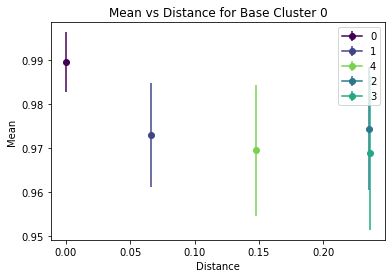

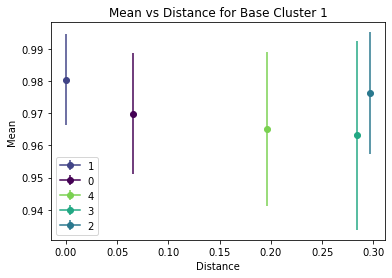

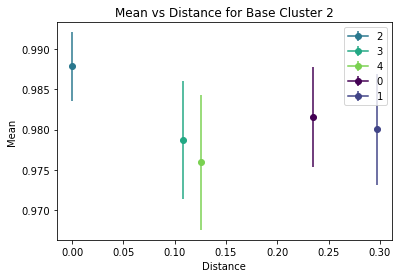

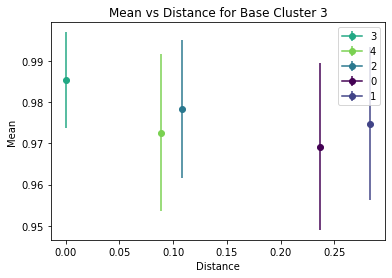

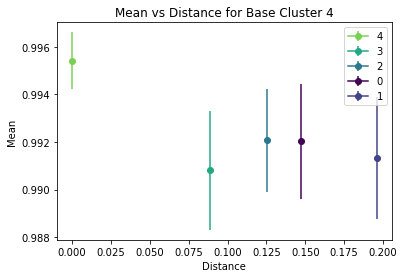

No handles with labels found to put in legend.


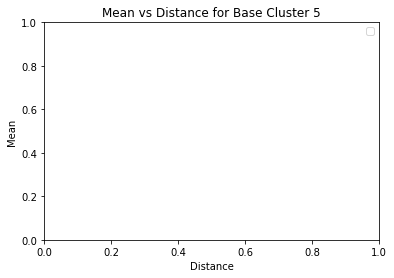

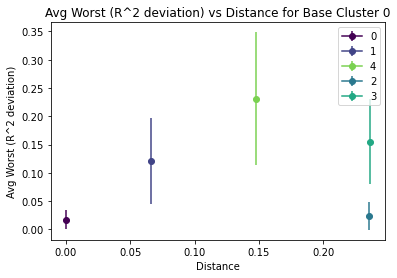

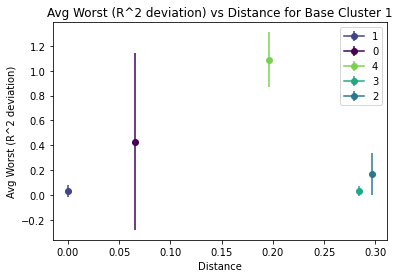

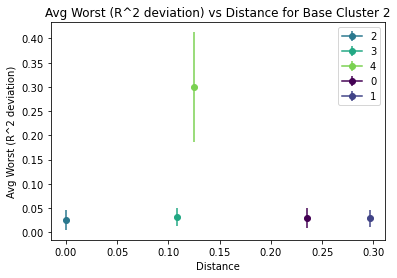

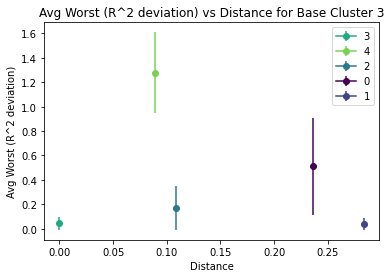

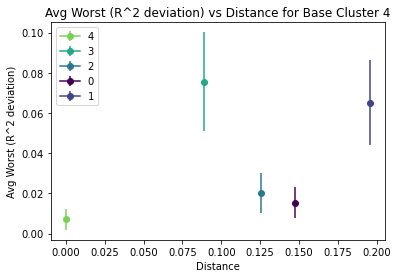

No handles with labels found to put in legend.


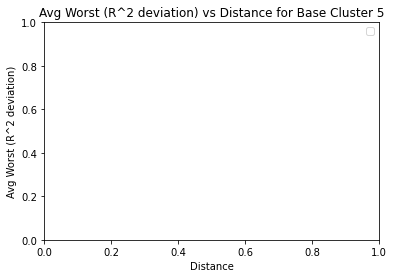

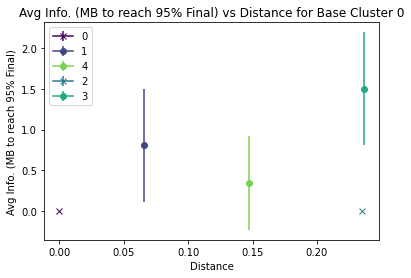

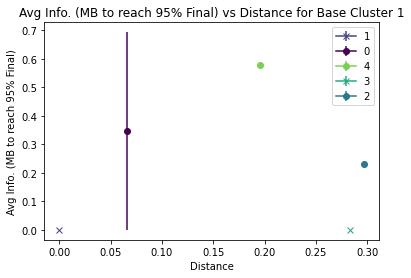

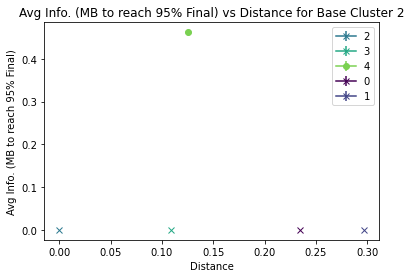

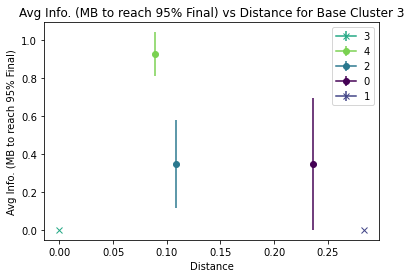

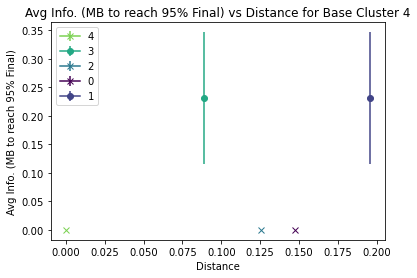

No handles with labels found to put in legend.


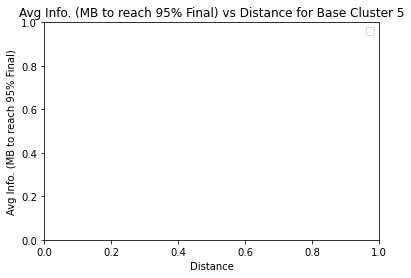

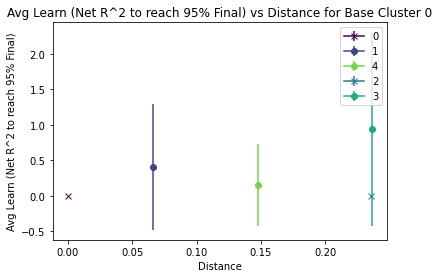

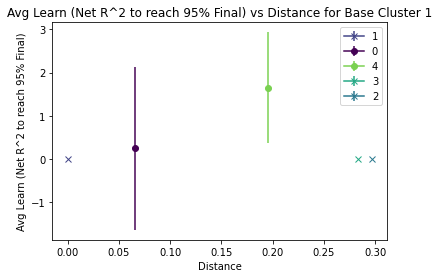

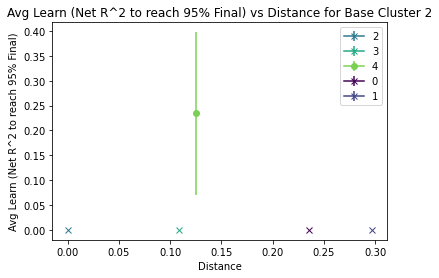

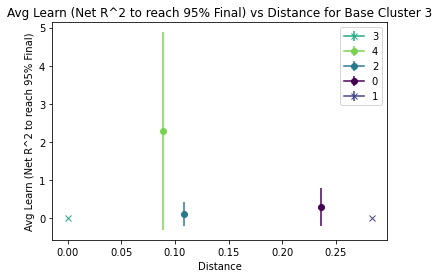

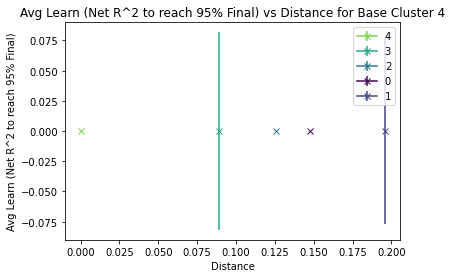

No handles with labels found to put in legend.


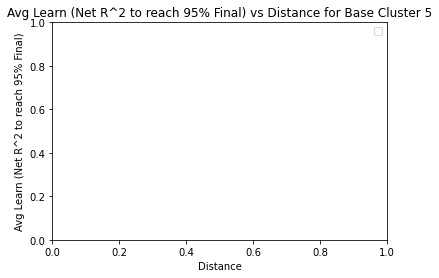

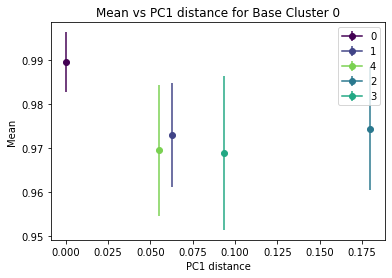

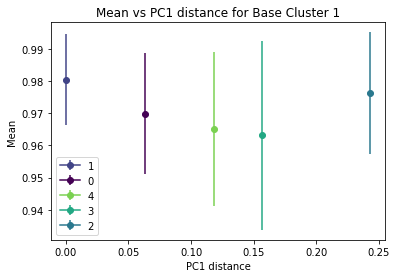

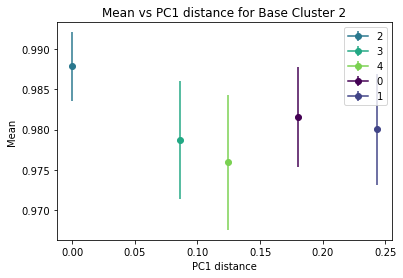

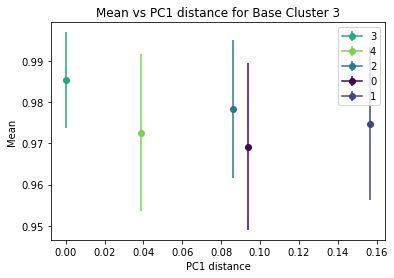

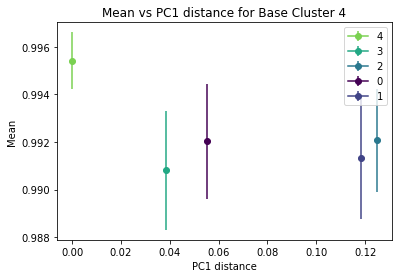

No handles with labels found to put in legend.


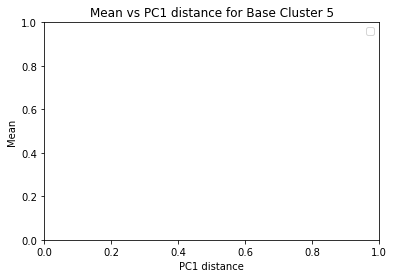

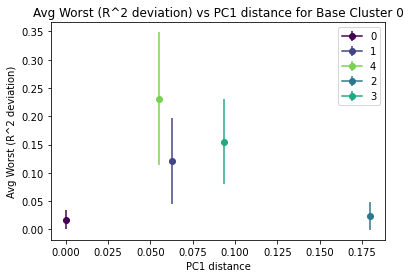

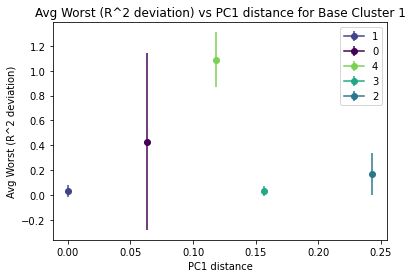

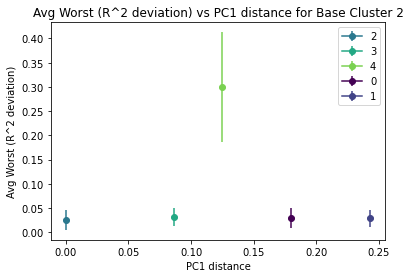

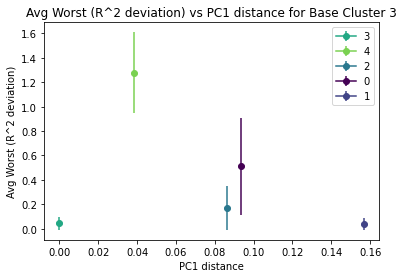

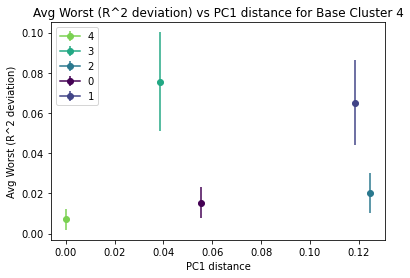

No handles with labels found to put in legend.


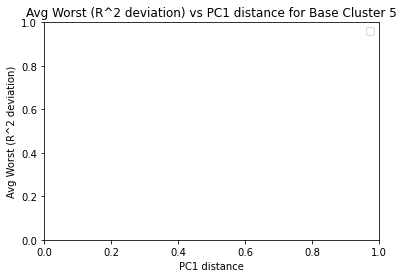

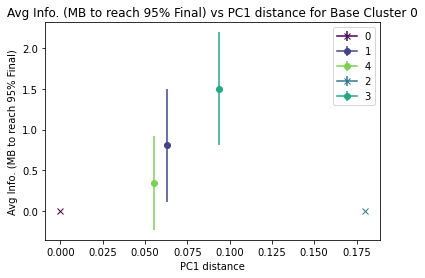

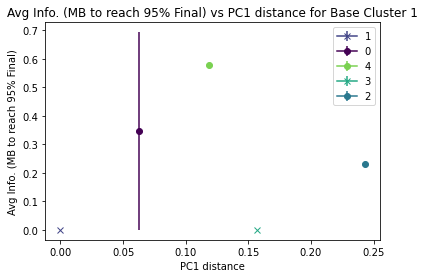

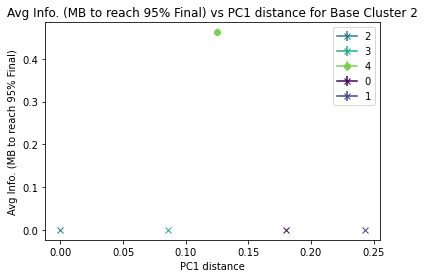

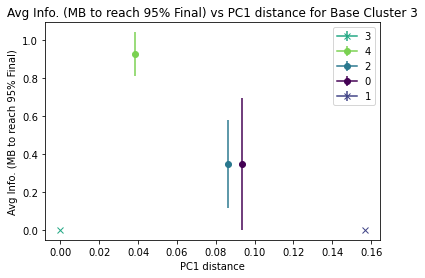

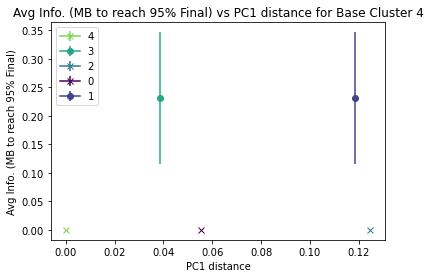

No handles with labels found to put in legend.


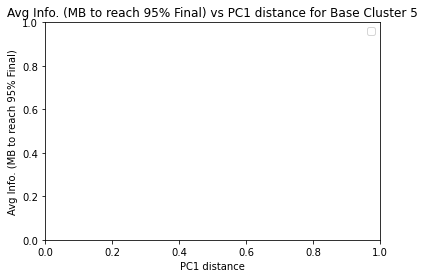

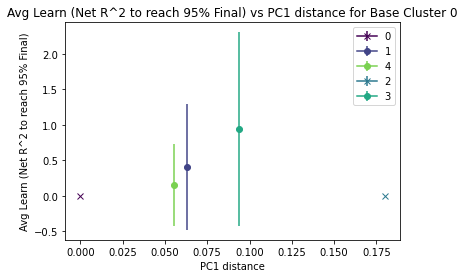

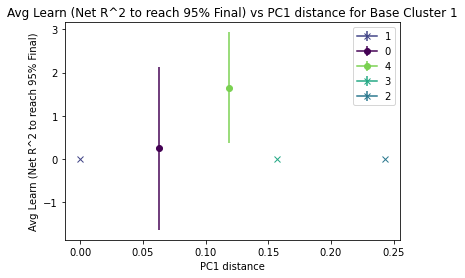

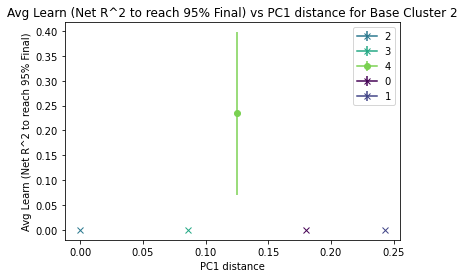

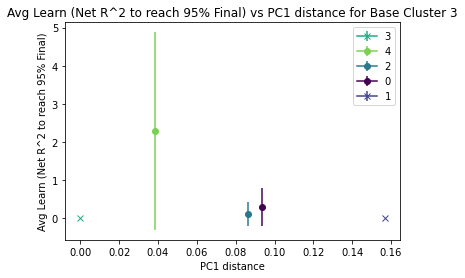

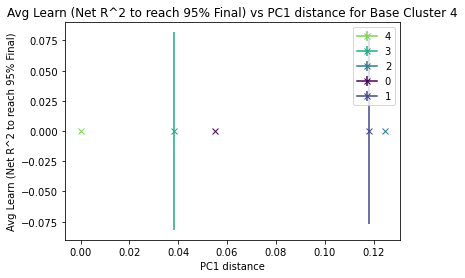

No handles with labels found to put in legend.


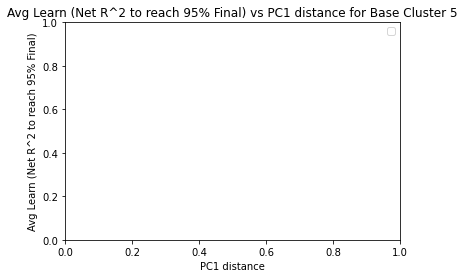

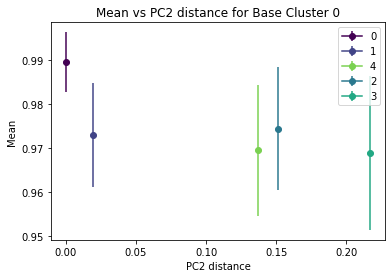

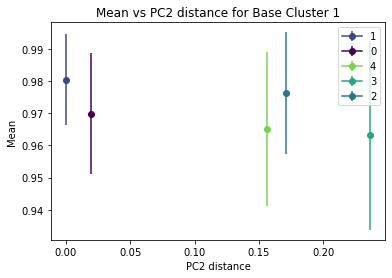

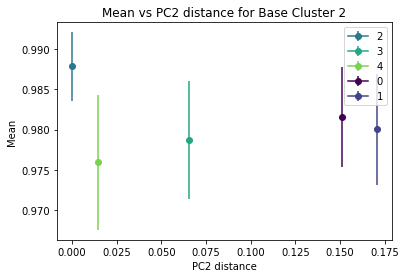

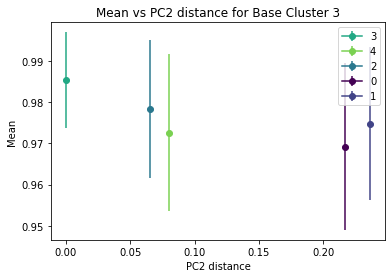

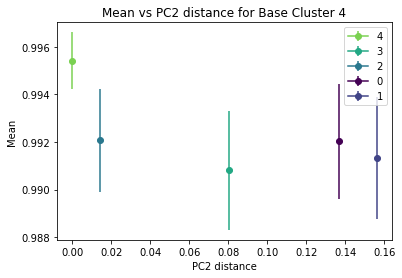

No handles with labels found to put in legend.


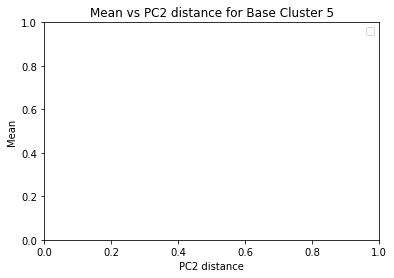

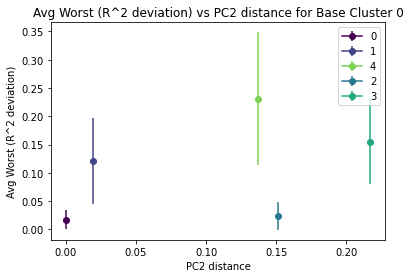

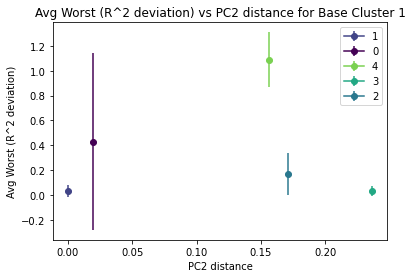

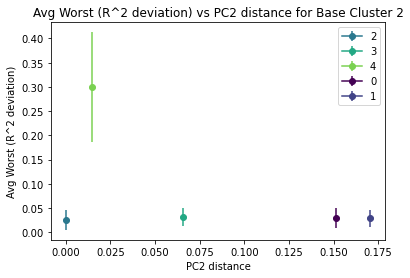

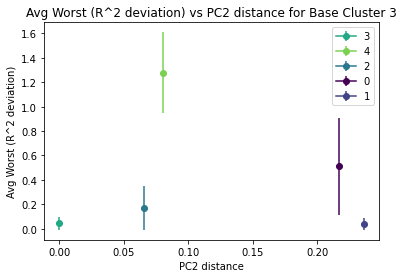

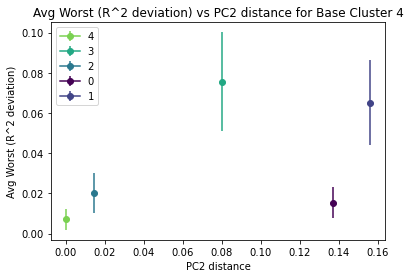

No handles with labels found to put in legend.


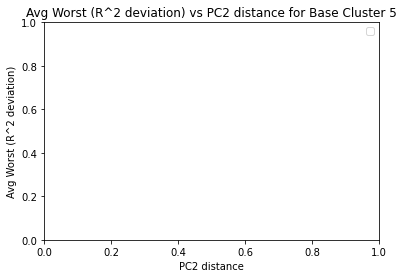

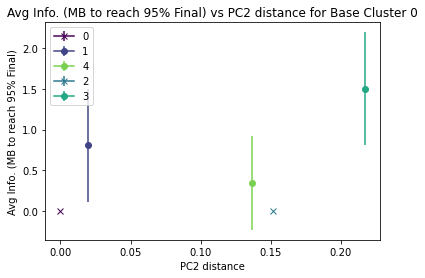

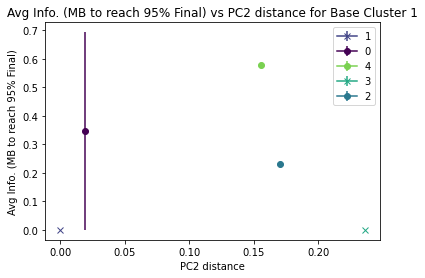

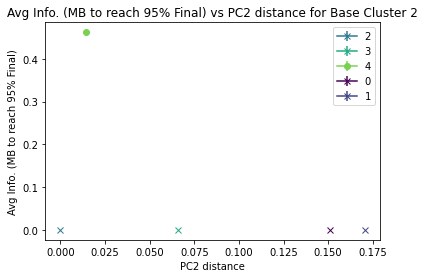

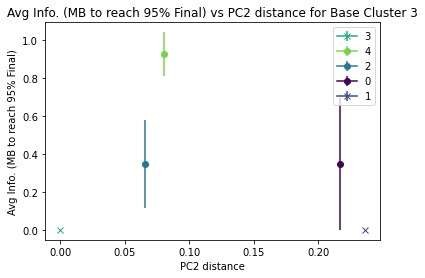

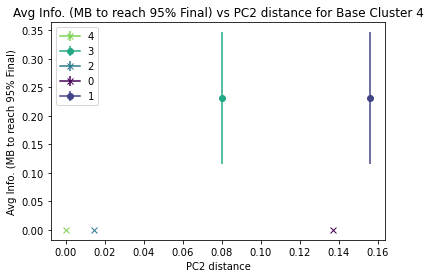

No handles with labels found to put in legend.


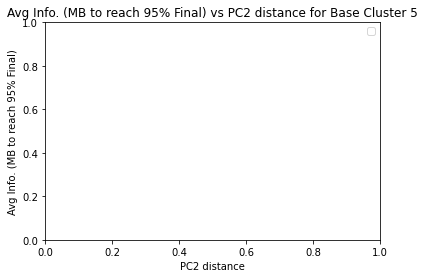

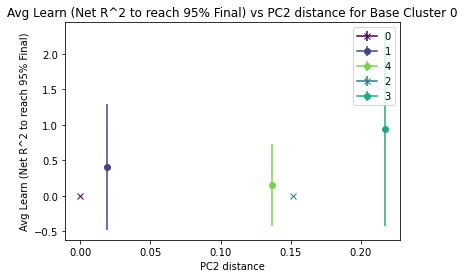

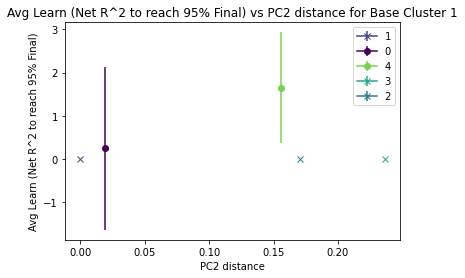

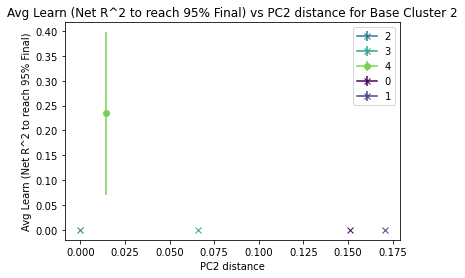

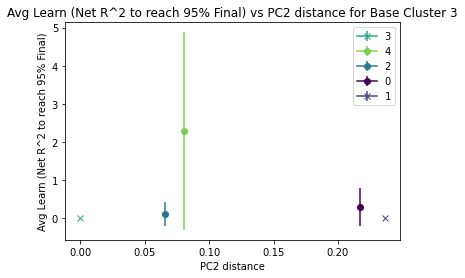

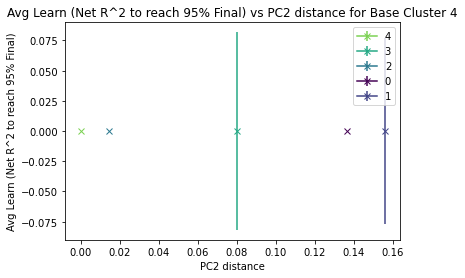

No handles with labels found to put in legend.


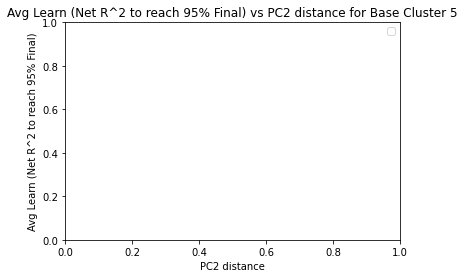

In [8]:
graphs={
0: ["Mean","Std"],
1: ["Avg Worst (R^2 deviation)","Worst Std"],
2: ["Avg Info. (MB to reach 95% Final)","Info Std"],
3: ["Avg Learn (Net R^2 to reach 95% Final)","Learn Std"],
}
x="Distance"

def make_plot(df,x,y,error,base):
    for i in df.iterrows():
        i=i[1]
        if i[y] == 0:
            marker="x"
        else:
            marker='o'
        plt.errorbar(i[x],i[y],yerr=i[error],color=i["color"],marker=marker,label=i["Cluster"])
    plt.legend()
    plt.title(f"{y} vs {x} for Base Cluster {base}")
    plt.ylabel(y)
    plt.xlabel(x)

for g in graphs:
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i)
        plt.savefig(fig_label,dpi=400)
        plt.show()
    
x="PC1 distance"
for g in graphs:
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i)
        plt.savefig(fig_label,dpi=400)
        plt.show()

x="PC2 distance"
for g in graphs:
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i)
        plt.savefig(fig_label,dpi=400)
        plt.show()

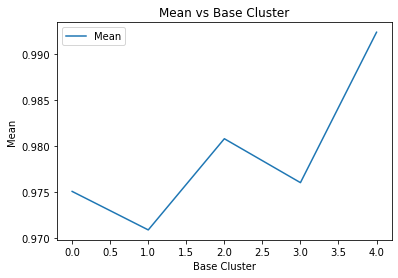

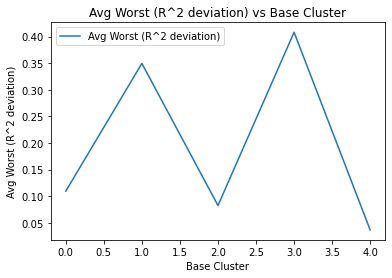

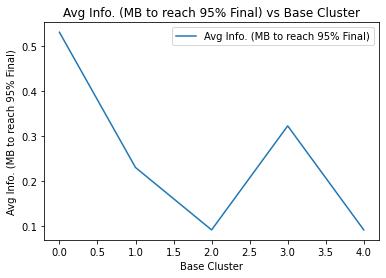

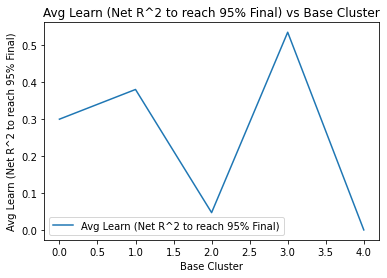

In [9]:
test=real_df.groupby("Base Cluster").mean()
for i in graphs:
    a,_=graphs[i]
    test.plot(y=a,ylabel=a,title=f"{a} vs Base Cluster")
    fig_label=f"META_{a}vsBC.png"
    plt.savefig(fig_label,dpi=400)
    plt.show()

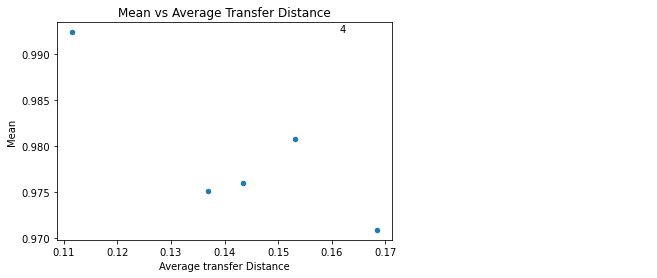

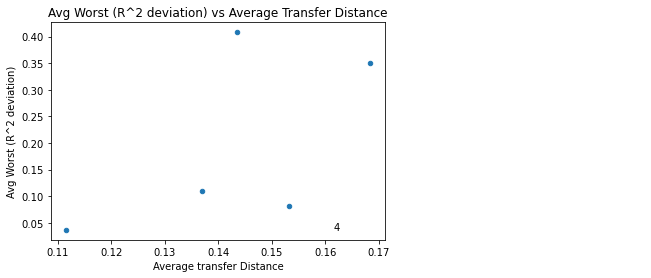

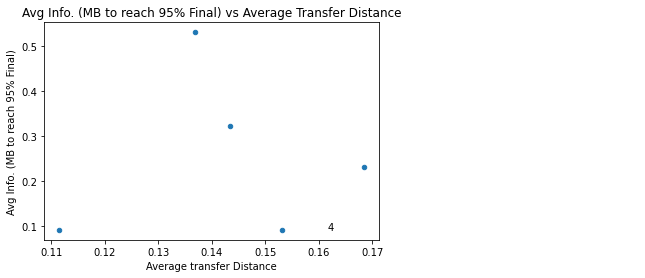

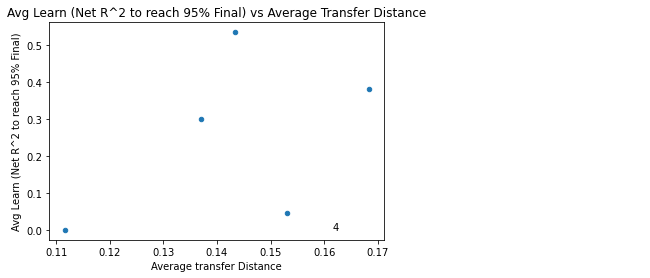

In [11]:
test['labels']=[0,1,2,3,4]
#if four
#test['labels']=[0,1,2,3]
distance_plots(test,"Mean")
plt.title("Mean vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_mean.png"
plt.savefig(fig_label,dpi=400)
plt.show()

distance_plots(test,"Avg Worst (R^2 deviation)")
plt.title("Avg Worst (R^2 deviation) vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_worst.png"
plt.savefig(fig_label,dpi=400)
plt.show()
distance_plots(test,"Avg Info. (MB to reach 95% Final)")
plt.title("Avg Info. (MB to reach 95% Final) vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_info.png"
plt.savefig(fig_label,dpi=400)
plt.show()
distance_plots(test,"Avg Learn (Net R^2 to reach 95% Final)")
plt.title("Avg Learn (Net R^2 to reach 95% Final) vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_learn.png"
plt.savefig(fig_label,dpi=400)
plt.show()

In [14]:
test=test.drop("Cluster",axis=1)
dfi.export(test, 'test.png')

In [15]:
#packages pngs
import os
folder=name[:-5]
os.mkdir(folder)
path=os.getcwd()
for i in os.listdir(path):
    if (i[-3:]) == "png":
        os.rename(f"{path}/{i}",f"{path}/{folder}/{i}")
    else:
        pass

In [16]:
path1=f"{path}/{folder}"
meta=path1+"/META"
pc1=path1+"/PC1"
pc2=path1+"/PC2"
rest=path1+"/regular"
tables=path1+"/Tables"
os.mkdir(meta)
os.mkdir(pc1)
os.mkdir(pc2)
os.mkdir(rest)
os.mkdir(tables)
for i in os.listdir(path1):
    if (i[-3:]) != "png":
        pass
    elif "META" in i:
        os.rename(f"{path1}/{i}",f"{meta}/{i}")
    elif "PC1" in i:
        os.rename(f"{path1}/{i}",f"{pc1}/{i}")
    elif "PC2" in i:
        os.rename(f"{path1}/{i}",f"{pc2}/{i}")
    elif "test" in i or "groupped" in i:
        os.rename(f"{path1}/{i}",f"{tables}/{i}")
    else:
        os.rename(f"{path1}/{i}",f"{rest}/{i}")
